In [1]:
import itertools
import math
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from dataset import *
from models import *
from sampler import *
from utils import *

imb_type = 'exp'
imb_factor = 0.01
noise_mode = 'imb'
noise_ratio = 0.0
resample_ratio = 1.0
rand_number = 0

batch_size = 128
lr = 0.1
num_epochs = 8
num_epochs_retrain = 4
print_freq = 100
num_workers = 0
gpu = 0

seed = 0
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
random.seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [2]:
# load data
transform = transforms.ToTensor()
train_dataset = FashionMNIST_LT(root='./data', imb_type=imb_type, imb_factor=imb_factor, noise_mode=noise_mode, noise_ratio=noise_ratio, resample_ratio=resample_ratio,
                         rand_number=rand_number, train=True, download=True, transform=transform)
test_dataset = FashionMNIST_LT(root='./data', train=False, download=True, transform=transform)

num_classes = train_dataset.cls_num
cls_num_list = train_dataset.get_cls_num_list()
print('cls num list:', cls_num_list)
inversed_freq = 1.0 / torch.Tensor(cls_num_list).cuda(gpu)

clean_targets = np.array(train_dataset.clean_targets)
targets = np.array(train_dataset.targets)
print('noise ratio:', (clean_targets != targets).mean())

cls num list: [6000, 3596, 2156, 1292, 774, 464, 278, 166, 100, 60]
noise ratio: 0.0


In [3]:
# torch.manual_seed(0)
model = LeNet2_FE()
classifier1 = Classifier(2, 10)
# torch.seed()
model = model.cuda(gpu)
classifier1 = classifier1.cuda(gpu)

sampler, criterion = None, nn.CrossEntropyLoss().cuda(gpu)
# sampler, criterion = ClassAwareSampler(train_dataset), nn.CrossEntropyLoss().cuda(gpu)
# sampler, criterion = None, nn.CrossEntropyLoss(weight=inversed_freq).cuda(gpu)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, shuffle=(sampler is None), num_workers=num_workers, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=num_workers, pin_memory=True)

optimizer = torch.optim.SGD(itertools.chain(model.parameters(), classifier1.parameters()), lr=lr)

for epoch in range(num_epochs):
    # training
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')

    # switch to train mode
    model.train()
    classifier1.train()

    for i, (images, target) in enumerate(train_loader):
        images = images.cuda(gpu, non_blocking=True)
        target = target.cuda(gpu, non_blocking=True)
        
        feat = model(images)
        output = classifier1(feat)
        loss = F.cross_entropy(output, target)

        # measure accuracy and record loss
        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        losses.update(loss.item(), images.size(0))
        top1.update(acc1[0], images.size(0))
        top5.update(acc5[0], images.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % print_freq == 0:
            out = ('Epoch: [{0}][{1}/{2}]\t'
                   'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                   'Prec@1 {top1.val:.3f} ({top1.avg:.3f})\t'
                   'Prec@5 {top5.val:.3f} ({top5.avg:.3f})').format(
                epoch, i, len(train_loader), loss=losses, top1=top1, top5=top5)
            # print(out)

    # test
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.3f')
    top5 = AverageMeter('Acc@5', ':6.3f')
    
    # switch to evaluate mode
    model.eval()
    classifier1.eval()

    test_preds = []
    test_targets = []
    
    with torch.no_grad():
        for i, (images, target) in enumerate(test_loader):
            images = images.cuda(gpu, non_blocking=True)
            target = target.cuda(gpu, non_blocking=True)
            
            # compute output
            feat = model(images)
            output = classifier1(feat)
            _, predicted = output.max(1)

            # measure accuracy and record loss
            acc1, acc5 = accuracy(output, target, topk=(1, 5))
            losses.update(loss.item(), images.size(0))
            top1.update(acc1[0], images.size(0))
            top5.update(acc5[0], images.size(0))
            
            _, pred = torch.max(output, 1)
            test_preds.extend(pred.cpu())
            test_targets.extend(target.cpu())

            if i % print_freq == 0:
                out = ('Test: [{0}/{1}]\t'
                       'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                       'Prec@1 {top1.val:.3f} ({top1.avg:.3f})\t'
                       'Prec@5 {top5.val:.3f} ({top5.avg:.3f})'.format(
                    i, len(test_loader), loss=losses, top1=top1, top5=top5))
                # print(out)

        cf = confusion_matrix(test_targets, test_preds).astype(float)
        cls_cnt = cf.sum(axis=1)
        cls_hit = np.diag(cf)
        cls_acc = cls_hit / cls_cnt

        out_acc = ('Results: Prec@1 {top1.avg:.3f} Prec@5 {top5.avg:.3f} Loss {loss.avg:.5f}'
                .format(top1=top1, top5=top5, loss=losses))
        out_cls_acc = 'Class Accuracy: %s' % (np.array2string(cls_acc, separator=',', formatter={'float_kind':lambda x: "%.3f" % x}))
        print(out_acc, end='   ')
        print(out_cls_acc)
    
    # if epoch > int(num_epochs * 0.8):
    #     _lr = lr * 0.01
    # elif epoch > int(num_epochs * 0.6):
    #     _lr = lr * 0.1
    # else:
    #     _lr = lr
    
    _lr = 0.5 * lr * (1 + math.cos((epoch + 1) / num_epochs * 3.1415926535))

    for param_group in optimizer.param_groups:
        param_group['lr'] = _lr


Results: Prec@1 35.040 Prec@5 71.490 Loss 0.41301   Class Accuracy: [0.934,0.979,0.925,0.000,0.000,0.666,0.000,0.000,0.000,0.000]
Results: Prec@1 43.420 Prec@5 72.190 Loss 0.40225   Class Accuracy: [0.950,0.955,0.807,0.790,0.000,0.840,0.000,0.000,0.000,0.000]
Results: Prec@1 44.400 Prec@5 77.500 Loss 0.63751   Class Accuracy: [0.939,0.972,0.787,0.810,0.000,0.932,0.000,0.000,0.000,0.000]
Results: Prec@1 46.150 Prec@5 82.600 Loss 0.66695   Class Accuracy: [0.901,0.974,0.939,0.814,0.000,0.987,0.000,0.000,0.000,0.000]
Results: Prec@1 43.720 Prec@5 78.670 Loss 0.31847   Class Accuracy: [0.976,0.943,0.888,0.653,0.000,0.912,0.000,0.000,0.000,0.000]
Results: Prec@1 45.910 Prec@5 82.190 Loss 0.30686   Class Accuracy: [0.954,0.957,0.903,0.815,0.000,0.962,0.000,0.000,0.000,0.000]
Results: Prec@1 45.890 Prec@5 83.730 Loss 0.22717   Class Accuracy: [0.949,0.963,0.925,0.783,0.000,0.969,0.000,0.000,0.000,0.000]
Results: Prec@1 45.660 Prec@5 84.650 Loss 0.28485   Class Accuracy: [0.950,0.962,0.929,0.7

In [4]:
cls_acc[0:3].mean(), cls_acc[3:7].mean(), cls_acc[7:10].mean()

(0.9470000000000001, 0.43125, 0.0)

In [5]:
sampler, criterion = ClassAwareSampler(train_dataset), nn.CrossEntropyLoss().cuda(gpu)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, shuffle=(sampler is None), num_workers=num_workers, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=num_workers, pin_memory=True)

classifier2 = copy.deepcopy(classifier1)
classifier2 = classifier2.cuda(gpu)

optimizer = torch.optim.SGD(classifier2.parameters(), lr=lr)

for epoch in range(num_epochs_retrain):
    # training
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')

    # switch to train mode
    model.eval()
    classifier2.train()

    for i, (images, target) in enumerate(train_loader):
        images = images.cuda(gpu, non_blocking=True)
        target = target.cuda(gpu, non_blocking=True)
        
        with torch.no_grad():
            feat = model(images)
        output = classifier2(feat.detach())
        loss = F.cross_entropy(output, target)

        # measure accuracy and record loss
        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        losses.update(loss.item(), images.size(0))
        top1.update(acc1[0], images.size(0))
        top5.update(acc5[0], images.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % print_freq == 0:
            out = ('Epoch: [{0}][{1}/{2}]\t'
                   'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                   'Prec@1 {top1.val:.3f} ({top1.avg:.3f})\t'
                   'Prec@5 {top5.val:.3f} ({top5.avg:.3f})').format(
                epoch, i, len(train_loader), loss=losses, top1=top1, top5=top5)
            # print(out)

    # test
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.3f')
    top5 = AverageMeter('Acc@5', ':6.3f')
    
    # switch to evaluate mode
    model.eval()
    classifier2.eval()

    test_preds = []
    test_targets = []
    
    with torch.no_grad():
        for i, (images, target) in enumerate(test_loader):
            images = images.cuda(gpu, non_blocking=True)
            target = target.cuda(gpu, non_blocking=True)
            
            # compute output
            feat = model(images)
            output = classifier2(feat)
            _, predicted = output.max(1)

            # measure accuracy and record loss
            acc1, acc5 = accuracy(output, target, topk=(1, 5))
            losses.update(loss.item(), images.size(0))
            top1.update(acc1[0], images.size(0))
            top5.update(acc5[0], images.size(0))
            
            _, pred = torch.max(output, 1)
            test_preds.extend(pred.cpu())
            test_targets.extend(target.cpu())

            if i % print_freq == 0:
                out = ('Test: [{0}/{1}]\t'
                       'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                       'Prec@1 {top1.val:.3f} ({top1.avg:.3f})\t'
                       'Prec@5 {top5.val:.3f} ({top5.avg:.3f})'.format(
                    i, len(test_loader), loss=losses, top1=top1, top5=top5))
                # print(out)

        cf = confusion_matrix(test_targets, test_preds).astype(float)
        cls_cnt = cf.sum(axis=1)
        cls_hit = np.diag(cf)
        cls_acc = cls_hit / cls_cnt

        out_acc = ('Results: Prec@1 {top1.avg:.3f} Prec@5 {top5.avg:.3f} Loss {loss.avg:.5f}'
                .format(top1=top1, top5=top5, loss=losses))
        out_cls_acc = 'Class Accuracy: %s' % (np.array2string(cls_acc, separator=',', formatter={'float_kind':lambda x: "%.3f" % x}))
        print(out_acc, end='   ')
        print(out_cls_acc)
    
    # if epoch > int(num_epochs * 0.8):
    #     _lr = lr * 0.01
    # elif epoch > int(num_epochs * 0.6):
    #     _lr = lr * 0.1
    # else:
    #     _lr = lr
    
    _lr = 0.5 * lr * (1 + math.cos((epoch + 1) / num_epochs * 3.1415926535))

    for param_group in optimizer.param_groups:
        param_group['lr'] = _lr


Results: Prec@1 59.010 Prec@5 95.610 Loss 1.11881   Class Accuracy: [0.845,0.956,0.658,0.828,0.507,0.888,0.187,0.300,0.386,0.346]
Results: Prec@1 59.650 Prec@5 96.320 Loss 1.05943   Class Accuracy: [0.794,0.954,0.676,0.798,0.449,0.872,0.234,0.443,0.473,0.272]
Results: Prec@1 60.520 Prec@5 96.320 Loss 0.93813   Class Accuracy: [0.811,0.953,0.599,0.803,0.550,0.868,0.210,0.517,0.487,0.254]
Results: Prec@1 60.380 Prec@5 96.320 Loss 0.94073   Class Accuracy: [0.788,0.953,0.575,0.799,0.557,0.864,0.237,0.523,0.486,0.256]


In [6]:
cls_acc[0:3].mean(), cls_acc[3:7].mean(), cls_acc[7:10].mean()

(0.7719999999999999, 0.6142500000000001, 0.42166666666666663)

In [7]:
torch.save({'state_dict_model': model.state_dict(),
            'state_dict_classifier1': classifier1.state_dict(),
            'state_dict_classifier2': classifier2.state_dict(),
}, 'checkpoints/fashionmnist_lt_ce.pth')

In [8]:
model = LeNet2_FE()
classifier1 = Classifier(2, 10)
classifier2 = Classifier(2, 10)
model = model.cuda(gpu)
classifier1 = classifier1.cuda(gpu)
classifier2 = classifier2.cuda(gpu)

checkpoint = torch.load('checkpoints/fashionmnist_lt_ce.pth')
model.load_state_dict(checkpoint['state_dict_model'])
classifier1.load_state_dict(checkpoint['state_dict_classifier1'])
classifier2.load_state_dict(checkpoint['state_dict_classifier2'])

<All keys matched successfully>

In [9]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=False, num_workers=num_workers, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=num_workers, pin_memory=True)

model.eval()
# classifier1.eval()
# classifier2.eval()
train_feats = []
train_targets = []
with torch.no_grad():
    for images, target in train_loader:
        images = images.cuda(gpu, non_blocking=True)
        target = target.cuda(gpu, non_blocking=True)
        feat = model(images)
        train_feats.extend(feat.cpu())
        train_targets.extend(target.cpu())
train_feats = torch.stack(train_feats)
train_targets = torch.stack(train_targets)

test_feats = []
test_targets = []
with torch.no_grad():
    for images, target in test_loader:
        images = images.cuda(gpu, non_blocking=True)
        target = target.cuda(gpu, non_blocking=True)
        feat = model(images)
        test_feats.extend(feat.cpu())
        test_targets.extend(target.cpu())
test_feats = torch.stack(test_feats)
test_targets = torch.stack(test_targets)

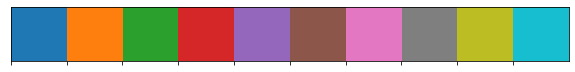

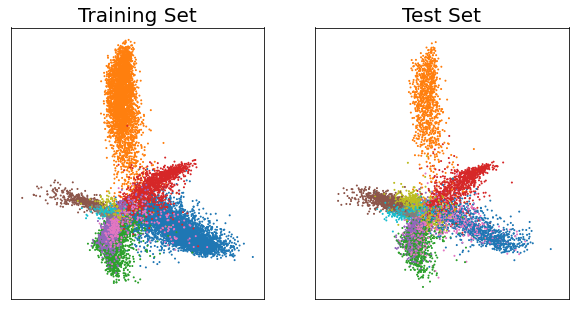

In [10]:
colors = sns.color_palette()
colors = np.array(colors)
sns.palplot(colors)

'''
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)
ax0.set_aspect(1)
ax1.set_aspect(1)
# plt.xlim(-12, 12)
# plt.ylim(-12, 12)
ax0.scatter(train_feats[:,0], train_feats[:,1], s=1, color=colors[train_targets])
ax1.scatter(test_feats[:,0], test_feats[:,1], s=1, color=colors[test_targets])
# weights = classifier1.weight.detach().cpu() # CE
# weights = classifier2.weight.detach().cpu() # cRT
# for i in range(num_classes):
#     ax0.arrow(0, 0, weights[i][0], weights[i][1], color=colors[i], width=0.1, head_width=0.5)
#     ax1.arrow(0, 0, weights[i][0], weights[i][1], color=colors[i], width=0.1, head_width=0.5)
plt.show()
'''
# sns.set(style='whitegrid')
# sns.color_palette('bright')

# plt.rcParams['font.family'] = 'Times New Roman'
# plt.rc('font', size=18)
# linewidth = 1.3
# fontsize=18

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
ax0.scatter(train_feats[:,0], train_feats[:,1], s=1, color=colors[train_targets])
ax1.scatter(test_feats[:,0], test_feats[:,1], s=1, color=colors[test_targets])
ax0.set_title('Training Set', fontsize=20)
ax1.set_title('Test Set', fontsize=20)
ax0.set_xticks([])
ax0.set_yticks([])
ax1.set_xticks([])
ax1.set_yticks([])
# plt.show()
plt.grid()
plt.savefig('fashionmnist_ce.jpg', dpi=300, bbox_inches='tight')
